In [7]:
import tensorflow as tf
import numpy as np
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector, Dropout
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
import nltk
import io
from nltk.tokenize.toktok import ToktokTokenizer
import unicodedata

# plot japanese lang
!pip install japanize-matplotlib
import japanize_matplotlib

# ignore warning
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

Using TensorFlow backend.


In [8]:
# mount google drive 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# load text file

**this dataset is aleady implemented a SentenceSpace**

In [0]:
num_example = 30000

# create each languages list
def create_lang_list(num_example):
    # load txt file
    lines =  io.open("/content/drive/My Drive/Colab Notebooks/raw.txt", encoding='UTF-8').read().strip().split('\n')

    word_pairs = [[w for w in l.split('\t')]  for l in lines[:num_example]]

    return zip(*word_pairs)

In [0]:
english_text, japanese_text = create_lang_list(num_example)

# Text Pre-processing

**Removing accented characters** 

e.g. é → e.

**Expanding Contractions** 

e.g. don't → do not, I'd → I would

**remove special word** 

e.g. remove "123#@!"

**Stemming**

 e.g. corder, codes → code

**Lemmatization**

 e.g. better → good

**Tokenize**

 e.g. I am going to restaurant → [[I], [am], [going], [to], [restaurant]]

# Removing accented characters

English might have accent like é but Japanese doesn't have any accent I just create different function to ascii for Japanese and English

In [0]:
# Removing accented characters
def english_unicode_to_ascii(text):
     return ''.join(ascii_text for ascii_text in unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore'))

def japanese_unicode_to_ascii(text):
    return ''.join(ascii_text for ascii_text in unicodedata.normalize('NFKD', text))

In [12]:
# e.g.
japanese_unicode_to_ascii("こんにちは。今日は"), english_unicode_to_ascii("Hello world é ")

('こんにちは。今日は', 'Hello world e ')

# Expanding Contractions
Japanese doesn't have a Contraction words so I just create a one function to expand Contractions for Engish

In [0]:
def expand_constraction(text):

    #  dic for expand constraction words
    constraction_dict= {
        "ain't": "is not",
        "aren't": "are not",
        "can't": "cannot",
        "can't've": "cannot have",
        "'cause": "because",
        "could've": "could have",
        "couldn't": "could not",
        "couldn't've": "could not have",
        "didn't": "did not",
        "doesn't": "does not",
        "don't": "do not",
        "hadn't": "had not",
        "hadn't've": "had not have",
        "hasn't": "has not",
        "haven't": "have not",
        "he'd": "he would",
        "he'd've": "he would have",
        "he'll": "he will",
        "he'll've": "he he will have",
        "he's": "he is",
        "how'd": "how did",
        "how'd'y": "how do you",
        "how'll": "how will",
        "how's": "how is",
        "I'd": "I would",
        "I'd've": "I would have",
        "I'll": "I will",
        "I'll've": "I will have",
        "I'm": "I am",
        "I've": "I have",
        "i'd": "i would",
        "i'd've": "i would have",
        "i'll": "i will",
        "i'll've": "i will have",
        "i'm": "i am",
        "i've": "i have",
        "isn't": "is not",
        "it'd": "it would",
        "it'd've": "it would have",
        "it'll": "it will",
        "it'll've": "it will have",
        "it's": "it is",
        "let's": "let us",
        "ma'am": "madam",
        "mayn't": "may not",
        "might've": "might have",
        "mightn't": "might not",
        "mightn't've": "might not have",
        "must've": "must have",
        "mustn't": "must not",
        "mustn't've": "must not have",
        "needn't": "need not",
        "needn't've": "need not have",
        "o'clock": "of the clock",
        "oughtn't": "ought not",
        "oughtn't've": "ought not have",
        "shan't": "shall not",
        "sha'n't": "shall not",
        "shan't've": "shall not have",
        "she'd": "she would",
        "she'd've": "she would have",
        "she'll": "she will",
        "she'll've": "she will have",
        "she's": "she is",
        "should've": "should have",
        "shouldn't": "should not",
        "shouldn't've": "should not have",
        "so've": "so have",
        "so's": "so as",
        "that'd": "that would",
        "that'd've": "that would have",
        "that's": "that is",
        "there'd": "there would",
        "there'd've": "there would have",
        "there's": "there is",
        "they'd": "they would",
        "they'd've": "they would have",
        "they'll": "they will",
        "they'll've": "they will have",
        "they're": "they are",
        "they've": "they have",
        "to've": "to have",
        "wasn't": "was not",
        "we'd": "we would",
        "we'd've": "we would have",
        "we'll": "we will",
        "we'll've": "we will have",
        "we're": "we are",
        "we've": "we have",
        "weren't": "were not",
        "what'll": "what will",
        "what'll've": "what will have",
        "what're": "what are",
        "what's": "what is",
        "what've": "what have",
        "when's": "when is",
        "when've": "when have",
        "where'd": "where did",
        "where's": "where is",
        "where've": "where have",
        "who'll": "who will",
        "who'll've": "who will have",
        "who's": "who is",
        "who've": "who have",
        "why's": "why is",
        "why've": "why have",
        "will've": "will have",
        "won't": "will not",
        "won't've": "will not have",
        "would've": "would have",
        "wouldn't": "would not",
        "wouldn't've": "would not have",
        "y'all": "you all",
        "y'all'd": "you all would",
        "y'all'd've": "you all would have",
        "y'all're": "you all are",
        "y'all've": "you all have",
        "you'd": "you would",
        "you'd've": "you would have",
        "you'll": "you will",
        "you'll've": "you will have",
        "you're": "you are",
        "you've": "you have"
    }

    #  define match pattern
    #  IGNORECASE → no matter if word is lowercase or uppercase
    #  DOTAIL → . is going to match \n
    contraction_pattern = re.compile('({})'.format('|'.join(constraction_dict.keys())),
                                                  flags=re.IGNORECASE | re.DOTALL)
    #  expand words
    def expand_match(constraction):
        # get constraction word
        match = constraction.group(0)
        first_char = match[0]
        #  get expand word from constraction dict
        expand_constraction = constraction_dict.get(match)\
                                                    if constraction_dict.get(match) \
                                                    else constraction_dict.get(match.lower())
        
        # create expand constraction
        expand_constraction = first_char + expand_constraction[1:]
        return expand_constraction
    
    expanded_text = contraction_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

In [14]:
# e.g.
expand_constraction("you're good I'd like to go he's she's")

'you are good I would like to go he is she is'

# remove special characters and create space between word and punctuation

replacing everything with space except(a-z, A-Z, "?", "!", "-", "ー", "Kanji", "Katakana", "Hiragana") 
create space between word and punctuation (? ! )

In [0]:
def replace_special_character_to_space(text):
    pattern = r"[^a-zA-Z\u3041-\u309F\u30A1-\u30FF\uFF66-\uFF9F\u4E00-\u9FD0\u309B\u3099\uFF9E\u309C\u309A\uFF9F?!\-/\s]+"
    text = re.sub(pattern, '', text).rstrip().strip()
    text = text.replace("・" , "")

    text = re.sub(r"([?!.,。、])", r" \1 ", text)
    text = text.lower()

    return text

In [16]:
# e.g.
replace_special_character_to_space("hello, . #@…123world."), replace_special_character_to_space("こん・にちは。・ いい天気。")

('hello  world', 'こんにちは いい天気')

# Stemming and Lemmatization
I will do stemming only english which can create a base form of a word from a given word. Japanese language doesn't need a stemming

In [0]:
def stemmer_word(text):
    ps = nltk.stem.PorterStemmer()
    text = ' '.join([ps.stem(word) for word in text.split()])
    return text

In [18]:
# e.g.
stemmer_word("hello world she has cat but he had dogs he is went to traveling")

'hello world she ha cat but he had dog he is went to travel'

# Normalize each word

In [0]:
def normalize_english(english_text, japanese_text):
    
    input_value = ()
    target_value = ()
    
    for en_text, ja_text in zip(english_text, japanese_text):
        
        # normalize English
        en_text = english_unicode_to_ascii(en_text)
        en_text = expand_constraction(en_text)
        en_text = replace_special_character_to_space(en_text)

        en_text = "<sos> " + en_text + " <eos>"
        
        input_value += (en_text, )

        # normalize Japanese
        ja_text = japanese_unicode_to_ascii(ja_text)
        ja_text = expand_constraction(ja_text)
        ja_text = replace_special_character_to_space(ja_text)

        ja_text = "<sos> " + ja_text + " <eos>"
        
        target_value += (ja_text, )

    return input_value, target_value

# get clean text data

In [0]:
input_value, target_value = normalize_english(english_text, japanese_text)

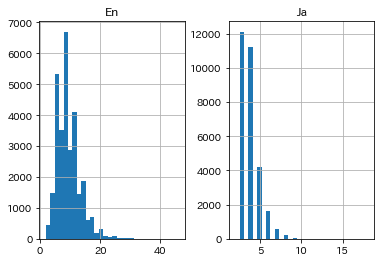

english length: 46
japanese length: 18


In [21]:
# empty lists
english_list = []
japanese_list = []

# populate the lists with sentence lengths
for i in input_value:
      english_list.append(len(i.split()))

for i in target_value:
      japanese_list.append(len(i.split()))

length_df = pd.DataFrame({'En': english_list, 'Ja': japanese_list})

length_df.hist(bins = 30)
plt.show()

# print max length
print("english length:", max(english_list))
print("japanese length:", max(japanese_list))

# tokenize
tokenize each language word based on space

In [0]:
# build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [23]:
# prepare English tokenizer
eng_tokenizer = tokenization(input_value)
eng_vocab_size = len(eng_tokenizer.word_index) + 1

# must all the sequences of the same length.
eng_length = 18
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 16772


In [24]:
# prepare Japanese tokenizer
ja_tokenizer = tokenization(target_value)
ja_vocab_size = len(ja_tokenizer.word_index) + 1

# must all the sequences of the same length.
ja_length = 18
print('japanese Vocabulary Size: %d' % ja_vocab_size)

japanese Vocabulary Size: 42613


In [0]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

# load Word2Vec pre train model
I will use pre-train model for embedding for English and Japanese words

In [1]:
import gensim
import gensim.models.keyedvectors as word2vec

# load pre-trian model for Japanese 
ja_word2vec_model = gensim.models.Word2Vec.load('/content/drive/My Drive/jawiki.doc2vec.dbow300d/jawiki.doc2vec.dbow300d.model')

# load pre-train model for English
en_word2vec_model = word2vec.KeyedVectors.load_word2vec_format("/content/drive/My Drive/GoogleNews-vectors-negative300.bin", binary=True, unicode_errors='ignore')

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [2]:
# similar word with country name
ja_word2vec_model.wv.most_similar("日本")

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('アメリカ', 0.6172695159912109),
 ('日本国内', 0.6169887781143188),
 ('米国', 0.5836105346679688),
 ('韓国', 0.583561897277832),
 ('海外', 0.5563584566116333),
 ('アジア', 0.5504777431488037),
 ('中国', 0.5415611863136292),
 ('アジア地域', 0.5271817445755005),
 ('台湾', 0.52516770362854),
 ('アジア諸国', 0.5203936100006104)]

In [3]:
# calculate word and word
ja_word2vec_model.wv.most_similar(positive=["お父さん", "死"], negative=["泣"])

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('息子', 0.5948961973190308),
 ('お母さん', 0.5658013820648193),
 ('母親', 0.559698760509491),
 ('おばあちゃん', 0.5565805435180664),
 ('父', 0.5533062815666199),
 ('母', 0.5530043840408325),
 ('パパ', 0.5508877635002136),
 ('亡き', 0.5500179529190063),
 ('婚約者', 0.5495285391807556),
 ('死ん', 0.546082615852356)]

In [4]:
# similar word with country name
en_word2vec_model.most_similar("Canada")

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('Canadian', 0.7513011693954468),
 ('Ontario', 0.6928848028182983),
 ('Nova_Scotia', 0.6792765259742737),
 ('Manitoba', 0.67861008644104),
 ('Alberta', 0.6736730337142944),
 ('Canadians', 0.6654781103134155),
 ('Quebec', 0.6514720320701599),
 ('British_Columbia', 0.6478375196456909),
 ('Peller_Estates_Icewine', 0.6433447003364563),
 ('Saskatchewan', 0.6383945941925049)]

In [5]:
# calculate word and word
en_word2vec_model.most_similar(positive=["programmer", "skill"], negative=["money"])

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('Programmer', 0.4614413380622864),
 ('3D_modeller', 0.4489377737045288),
 ('skils', 0.4471549987792969),
 ('puzzle_solver', 0.4467487633228302),
 ('Jon_Shiring', 0.4382207989692688),
 ('programmers', 0.4363787770271301),
 ('coder', 0.434060662984848),
 ('skills', 0.42342013120651245),
 ('skillset', 0.42207223176956177),
 ('animator', 0.4214385449886322)]

In [0]:
# get weights
# English
input_embedding_matrix = np.zeros((eng_vocab_size, 300))
for word, i in eng_tokenizer.word_index.items():
    if i >= num_example:
        continue
    try:
        input_embedding_matrix[i] = en_word2vec_model.get_vector(word)
    except KeyError:
        continue

# Japanese
target_embedding_matrix = np.zeros((ja_vocab_size, 300))
for word, i in ja_tokenizer.word_index.items():
    if i >= num_example:
        continue
    try:
        target_embedding_matrix[i] = ja_word2vec_model.wv.get_vector(word)
    except KeyError:
        continue

In [31]:
input_embedding_matrix.shape, target_embedding_matrix.shape

((16772, 300), (42613, 300))

# Create train data

In [0]:
from sklearn.model_selection import train_test_split

# split data into train and test set
X_train, X_test,  y_train, y_test = train_test_split(input_value, target_value, test_size=0.3, random_state = 42)

In [0]:
# prepare training data
X_train = encode_sequences(eng_tokenizer, eng_length, X_train)
Y_train = encode_sequences(ja_tokenizer, ja_length, y_train)

# prepare validation data
X_test = encode_sequences(eng_tokenizer, eng_length, X_test)
Y_test = encode_sequences(ja_tokenizer, ja_length, y_test)


In [38]:
print(X_train.shape), print(Y_train.shape), print(X_test.shape), print(Y_test.shape)

(35000, 18)
(35000, 18)
(15000, 18)
(15000, 18)


(None, None, None, None)

# Model building

In [0]:
# build NMT model
def define_model(in_vocab,out_vocab, in_timesteps,out_timesteps,units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    Dropout(rate=0.6)
    model.add(RepeatVector(out_timesteps))
    Dropout(rate=0.6)
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

In [40]:
# model compilation
model = define_model(eng_vocab_size, ja_vocab_size, eng_length, ja_length, 512)




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
import keras.backend as K

#precision
def precision(y_true, y_pred):
    true_positives = K.sum(K.cast(K.greater(K.clip(y_true * y_pred, 0, 1), 0.20), 'float32'))
    pred_positives = K.sum(K.cast(K.greater(K.clip(y_pred, 0, 1), 0.20), 'float32'))

    precision_v = true_positives / (pred_positives + K.epsilon())
    return precision_v

#recall
def recall(y_true, y_pred):
    true_positives = K.sum(K.cast(K.greater(K.clip(y_true * y_pred, 0, 1), 0.20), 'float32'))
    poss_positives = K.sum(K.cast(K.greater(K.clip(y_true, 0, 1), 0.20), 'float32'))

    recall_v = true_positives / (poss_positives + K.epsilon())
    return recall_v

#f1 score
def f1_score(y_true, y_pred):
    precision_v = precision(y_true, y_pred)
    recall_v = recall(y_true, y_pred)
    f1_score_v = 2 * precision_v * recall_v / (precision_v + recall_v)

    return f1_score_v


In [42]:
# optimize loss function
rms = optimizers.RMSprop()

model.compile(optimizer=rms, loss='sparse_categorical_crossentropy', metrics=['accuracy', precision, recall, f1_score])

In [43]:
# checkpoint
filename = 'model.h1.22_Nov_19'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# train model
history = model.fit(X_train, Y_train.reshape(Y_train.shape[0], Y_train.shape[1], 1),
                    epochs=10, batch_size=128, validation_split = 0.3, callbacks=[checkpoint],                    
                    verbose=1)




Train on 24500 samples, validate on 10500 samples
Epoch 1/10





24500/24500 [==============================] - 100s 4ms/step - loss: 1.5637 - acc: 0.8575 - precision: 2699618129720.2451 - recall: 5404.9489 - f1_score: 2773.4045 - val_loss: 1.3181 - val_acc: 0.8789 - val_precision: 1381.3799 - val_recall: 6682.0910 - val_f1_score: 2289.2440

Epoch 00001: val_loss improved from inf to 1.31813, saving model to model.h1.22_Nov_19
Epoch 2/10
24500/24500 [==============================] - 89s 4ms/step - loss: 1.1783 - acc: 0.8779 - precision: 2305.5447 - recall: 11162.2388 - f1_score: 3821.3625 - val_loss: 1.2112 - val_acc: 0.8794 - val_precision: 3113.0769 - val_recall: 14851.6824 - val_f1_score: 5146.7271

Epoch 00002: val_loss improved from 1.31813 to 1.21115, saving model to model.h1.22_Nov_19
Epoch 3/10
24500/24500 [==============================] - 89s 4ms/step - loss: 1.1304 - acc: 0.8808 - precision: 2674.7526 - recall: 12850.4331 - f1_score: 4427.5253 - val_loss: 1.2297 - val_a

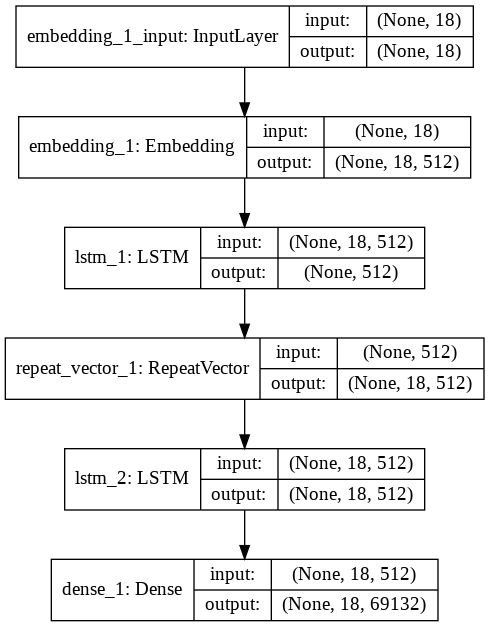

In [44]:
from keras.utils import plot_model

# model plot
plot_model(model, to_file='train-bert.png', show_shapes=True)

dict_keys(['val_loss', 'val_acc', 'val_precision', 'val_recall', 'val_f1_score', 'loss', 'acc', 'precision', 'recall', 'f1_score'])


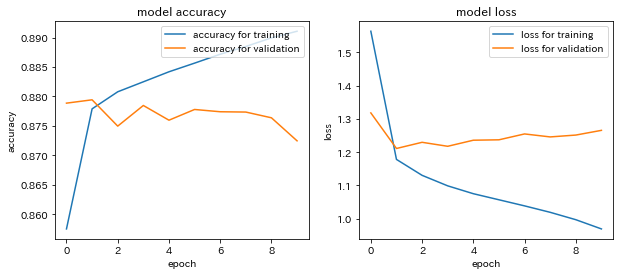

In [45]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,4))
print(history.history.keys())
def plot_history_acc(history):
    # plot the accuracy
    ax1.plot(history.history['acc'],label="accuracy for training")
    ax1.plot(history.history['val_acc'],label="accuracy for validation")
    ax1.set_title('model accuracy')
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('accuracy')
    ax1.legend(loc='upper right')

def plot_history_loss(history):
    # Plot the loss
    ax2.plot(history.history['loss'],label="loss for training")
    ax2.plot(history.history['val_loss'],label="loss for validation")
    ax2.set_title('model loss')
    ax2.set_xlabel('epoch')
    ax2.set_ylabel('loss')
    ax2.legend(loc='upper right')



plot_history_loss(history)
plot_history_acc(history)
plt.show()

In [0]:
# load model data 
# model = load_model('model.h1.22_Nov_19')

# predict
preds = model.predict_classes(X_test)

In [0]:
X_test.reshape((X_test.shape[0],X_test.shape[1]))

In [0]:
Y_test.shape

(3000, 12)

In [0]:
preds.shape

(3000, 12)

In [0]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [0]:
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], ja_tokenizer)

        if j > 0:
            if (t == get_word(i[j-1], ja_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t) 

    preds_text.append(' '.join(temp))

In [0]:
# view actual sentence anf predict result
pred_df = pd.DataFrame({'actual' : y_test, 'predicted' : preds_text})

In [0]:
pred_df.sample(50)

,actual,predicted
2871,<sos> それで済ますわけには いかないな <eos>,sos でも eos
2195,<sos> 手配 前科 前歴 該当なし <eos>,sos いや eos
1437,<sos> あの男が 日の光から逃げるために作った <eos>,sos eos
1285,<sos> あの動きさ <eos>,sos ああ eos
2621,<sos> この雨の中 一晩中 墓地にいたい ? <eos>,sos eos
1453,<sos> そういう勤務記録を提出しろ <eos>,sos でも eos
1505,<sos> しかし 経営者というのも <eos>,sos ああ eos
1019,<sos> 最新の予想を見ていたのですが <eos>,sos eos
2966,<sos> 弱いんだ <eos>,sos eos
2395,<sos> うん太っているエイミー <eos>,sos ああ eos


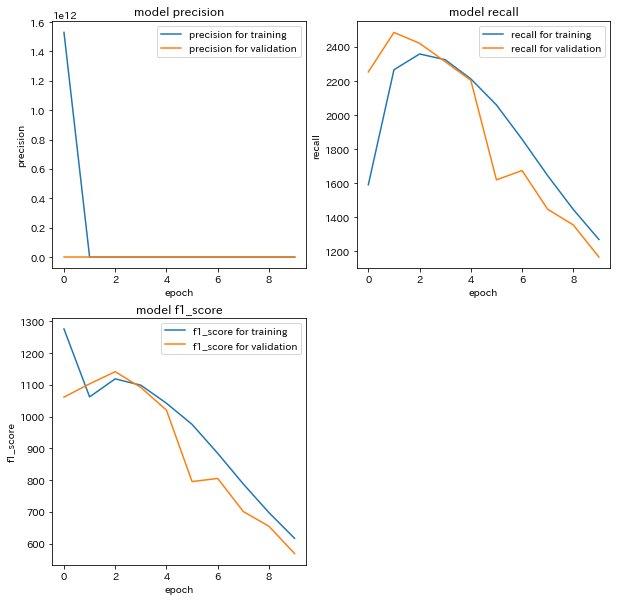

In [0]:
fig, ax = plt.subplots(nrows=2,ncols=2,figsize=(10,10))


def plot_history_precision(history):
    # Plot the loss
    ax[0, 0].plot(history.history['precision'],label="precision for training")
    ax[0, 0].plot(history.history['val_precision'],label="precision for validation")
    ax[0, 0].set_title('model precision')
    ax[0, 0].set_xlabel('epoch')
    ax[0, 0].set_ylabel('precision')
    ax[0, 0].legend(loc='upper right')


def plot_history_recall(history):
    # Plot the loss
    ax[0, 1].plot(history.history['recall'],label="recall for training")
    ax[0, 1].plot(history.history['val_recall'],label="recall for validation")
    ax[0, 1].set_title('model recall')
    ax[0, 1].set_xlabel('epoch')
    ax[0, 1].set_ylabel('recall')
    ax[0, 1].legend(loc='upper right')


def plot_history_f1_score(history):
    # Plot the loss
    ax[1, 0].plot(history.history['f1_score'],label="f1_score for training")
    ax[1, 0].plot(history.history['val_f1_score'],label="f1_score for validation")
    ax[1, 0].set_title('model f1_score')
    ax[1, 0].set_xlabel('epoch')
    ax[1, 0].set_ylabel('f1_score')
    ax[1, 0].legend(loc='upper right')

ax[1,1].axis('off')

plot_history_precision(history)
plot_history_recall(history)
plot_history_f1_score(history)

plt.show()